# Image Classification (Brain Tumor MRI)
![image](thumbnail.jpg)

# Packages

In [2]:
# Standard
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Images
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Utility
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Neural network
import torch
import torch.nn as nn
from torch import optim

# Evaluation
from torchmetrics import Precision, Recall

# Transform for images

In [8]:
# Create transform for training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(contrast=0.5, saturation=0.2),
    transforms.ToTensor()
])

# Create transform for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# Import training dataset

In [13]:
#Import training folder
train_data = ImageFolder(
    "data/training",
    transform = train_transform
)

#Create data loader
dataloader_train = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
    )

#Make dataloader iterable
images, labels = next(iter(dataloader_train))

#Reshape image[0] tensor from batch
image = images[0].squeeze().permute(1, 2, 0)
image.size()

torch.Size([128, 128, 3])

# Save names for labels

In [11]:
# Names mapped to labels in dictionary
names = train_data.class_to_idx

# Keys from dictionary to list
keys = list(names.keys())

# Show first image in batch

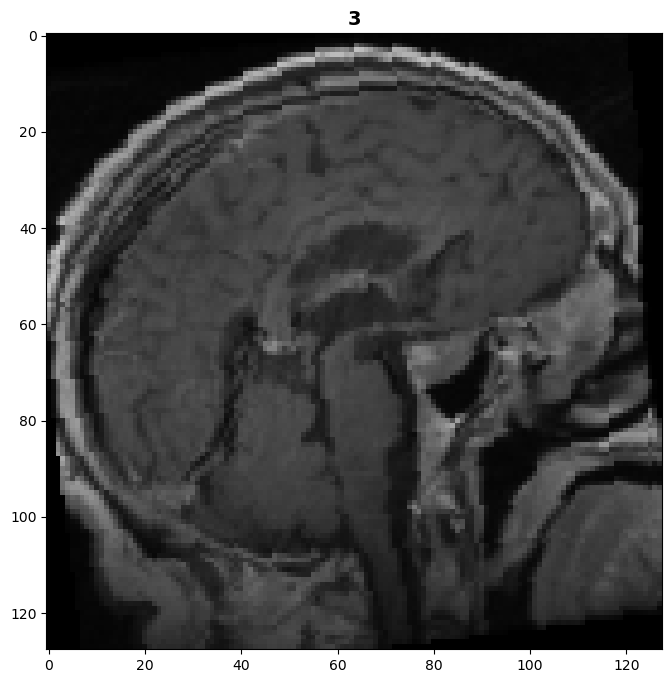

In [14]:
# Display images[0] from batch with matching labels[0] from batch
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(keys[int(labels[0])], fontsize = 14, fontweight = "bold")
plt.show()

# Import testing dataset

In [221]:
#Import testing folder
test_data = ImageFolder(
    "data/testing",
    transform = test_transform
)

#Create data loader
dataloader_test = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = True
    )

#Make dataloader iterable
test_images, test_labels = next(iter(dataloader_test))

# CNN

In [222]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Extract features
        self.extract = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Dropout(p = 0.4),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, n_classes)
        )

    # Forward
    def forward(self, x):
        x = self.extract(x)
        x = self.classifier(x)
        return x

# Define model, loss function and optimizer

In [223]:
# Model
net = Net(n_classes=4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience=3, factor=0.5)

# Define metrics

In [224]:
# Defining metrics
metric_precision = Precision(task="multiclass", num_classes=4, average="weighted")
metric_recall = Recall(task="multiclass", num_classes=4, average="weighted")

# Training and evaluation loop

In [225]:
# Run n epochs
n_epochs = 20

# Train and test losses
train_losses = []
test_losses = []

# Train and test accuracy
train_accuracies = []
test_accuracies = []

# Run loop
for epoch in range(n_epochs):
    train_running_loss = 0.0
    train_correct = 0.0
    train_count = 0.0
    for images, labels in dataloader_train:
        optimizer.zero_grad()

        # Forward pass
        output = net(images)

        # Accuracy
        _, pred = torch.max(output, 1)
        train_correct += (pred == labels).sum().item()
        train_count += labels.size(0)

        # Backpropagation and optimization
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

    # Epoch train performance
    train_loss = train_running_loss / len(dataloader_train)
    train_losses.append(train_loss)

    # Train accuracy
    train_accuracy = train_correct / train_count
    train_accuracies.append(train_accuracy)
    
    # Evaluate model performance on test data
    net.eval()
    true_labels = []
    pred_labels = []
    test_running_loss = 0.0
    test_correct = 0.0
    test_count = 0.0
    with torch.no_grad():
        for test_images, test_labels in dataloader_test:
            test_output = net(test_images)
            loss = criterion(test_output, test_labels)

            # Predictions
            _, pred_test = torch.max(test_output, 1)
            true_labels.extend(test_labels)
            pred_labels.extend(pred_test)

            # Accuracy
            test_correct += (pred_test == test_labels).sum().item()
            test_count += test_labels.size(0)

            # Metrics
            metric_precision(pred_test, test_labels)
            metric_recall(pred_test, test_labels)

            # Loss
            test_running_loss += loss.item()

    # Epoch test performance
    test_loss = test_running_loss / len(dataloader_test)
    test_losses.append(test_loss)

    # Update learning rate based on test loss
    scheduler.step(metrics=test_loss)

    # Test accuracy
    test_accuracy = test_correct / test_count
    test_accuracies.append(test_accuracy)

    # Compute metrics for test images
    precision = metric_precision.compute()
    recall = metric_recall.compute()

    # Print epoch results
    print(f'Epoch: {epoch + 1} \nTrain accuracy: {train_accuracy:.4f} | Test accuracy: {test_accuracy:.4f} \nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} \nTest precision: {precision:.4f} | Test recall: {recall:.4f}\n')

Epoch: 1 
Train accuracy: 0.5348 | Test accuracy: 0.3553 
Train loss: 4.8588 | Test loss: 7.6618 
Test precision: 0.3866 | Test recall: 0.3553

Epoch: 2 
Train accuracy: 0.6760 | Test accuracy: 0.4162 
Train loss: 0.8967 | Test loss: 2.7089 
Test precision: 0.4116 | Test recall: 0.3858

Epoch: 3 
Train accuracy: 0.7491 | Test accuracy: 0.4873 
Train loss: 0.6448 | Test loss: 2.3751 
Test precision: 0.4304 | Test recall: 0.4196

Epoch: 4 
Train accuracy: 0.7861 | Test accuracy: 0.5863 
Train loss: 0.5574 | Test loss: 2.5018 
Test precision: 0.4731 | Test recall: 0.4613

Epoch: 5 
Train accuracy: 0.8174 | Test accuracy: 0.5812 
Train loss: 0.4831 | Test loss: 1.8382 
Test precision: 0.4897 | Test recall: 0.4853

Epoch: 6 
Train accuracy: 0.8171 | Test accuracy: 0.6041 
Train loss: 0.4938 | Test loss: 2.0150 
Test precision: 0.5087 | Test recall: 0.5051

Epoch: 7 
Train accuracy: 0.8282 | Test accuracy: 0.5838 
Train loss: 0.4418 | Test loss: 1.8769 
Test precision: 0.5231 | Test recall: 

# Save CNN

In [226]:
model = torch.save(net, "CNN_brain_mri_model.pth")

# Display train and test loss

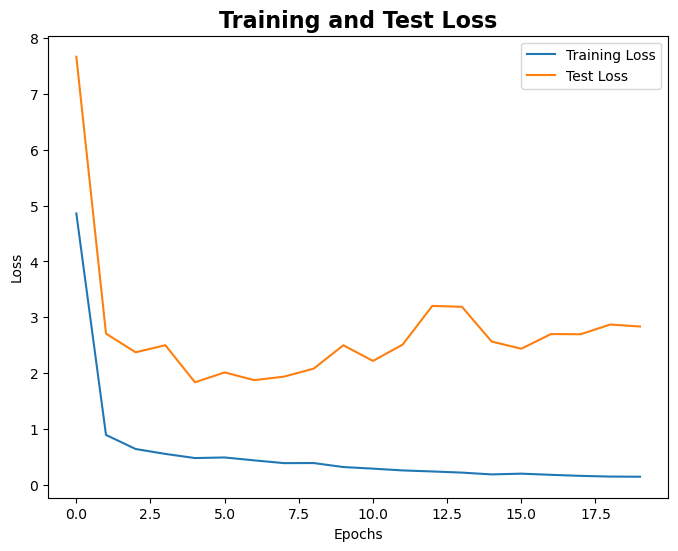

In [227]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss", fontweight = "bold", fontsize = 16)
plt.legend()
plt.show()

# Display train and test accuracy

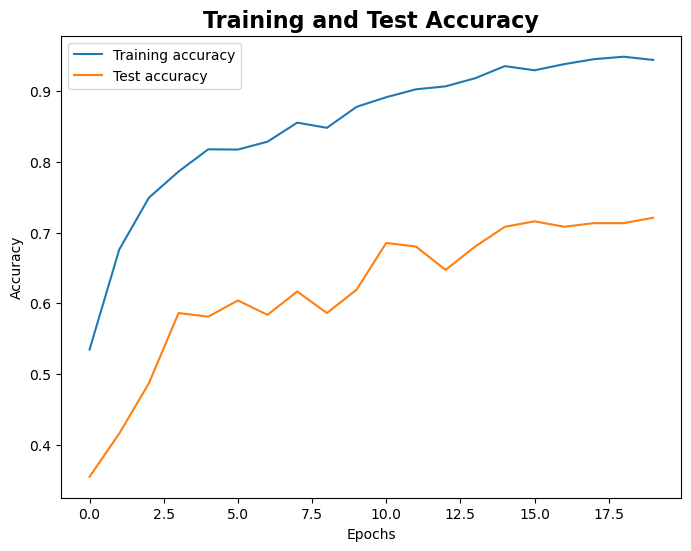

In [228]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy", fontweight = "bold", fontsize = 16)
plt.legend()
plt.show()

# Display confusion matrix from test data

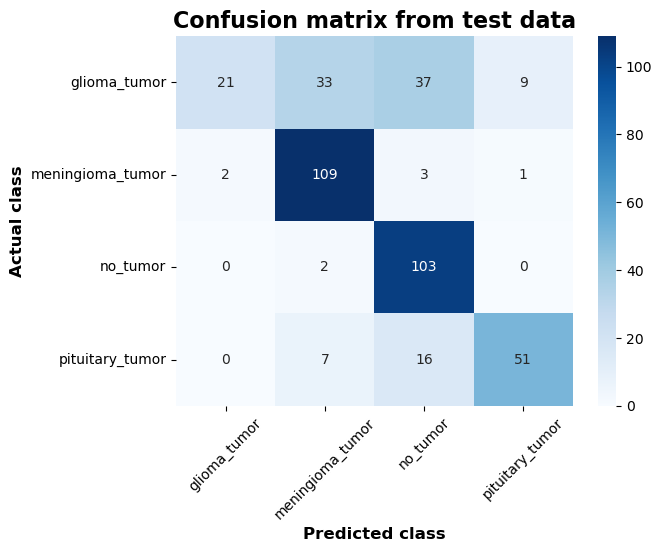

In [229]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="0.0f")
plt.title("Confusion matrix from test data", fontweight = "bold", fontsize = 16)
plt.xlabel("Predicted class", fontweight = "bold", fontsize = 12)
plt.ylabel("Actual class", fontweight = "bold", fontsize = 12)
plt.xticks(np.arange(4)+0.5, keys, rotation = 45)
plt.yticks(np.arange(4)+0.5, keys, rotation = 0)
plt.show()